
<h1 align="center">Assignment 2</h1>
<h3 style="display:block; margin-top:5px;" align="center">Online Tracking and Privacy</h3>    
<br>

In [39]:
import os
from collections import defaultdict
import seaborn as sns
import pandas as pd
import json
import tldextract
from datetime import datetime

In [37]:
"""
This function loads the har files obtained from the website 
"""
def load_file(path):
    with open(path, 'r', encoding='utf-8') as file:
        return json.load(file)

"""
This function obtains the domains of the urls.

"""
def extract_domain_info(url):
    domain_info = tldextract.extract(url)
    return domain_info.registered_domain
"""
This function obtains the entity_name of the organization that owns the domain names of the request urls
"""
def extract_entity_name(domain, entity_map):
    domain_info = tldextract.extract(domain)
    registered_domain = domain_info.registered_domain
    return entity_map.get(registered_domain, {"entityName": "Unknown"})["entityName"]

"""
This function obtains the domains of the urls.

"""
def extract_domain_info(url):
    domain_info = tldextract.extract(url)
    return domain_info.registered_domain


In [18]:
#Open document with the statistics of the crawler
stats = load_file("../analysis/stats.json")
directory_allow = '../crawl_data_allow'
directory_block = '../crawl_data_block'

### Exercise 1
- Data missing?

In [116]:
data = {
    'Error type': ['Page load timeout', 'Consent click failure'],
    'Crawl-Accept': ["?", "?"],  
    'Crawl-Block': [len(stats["time_out"]), len(stats["failed_to_find_accept"]) ]  
}

create_table(data)

,Error type,Crawl-Accept,Crawl-Block
0,Page load timeout,?,7
1,Consent click failure,?,28


## Exercise 2

- Page load time

In [15]:
page_load_times_allow = [j for i in stats["page_load_times_allow"] for j in i]
page_load_times_block = [j for i in stats["page_load_times_block"] for j in i]

<Axes: xlabel='Crawl Type', ylabel='Page load time'>

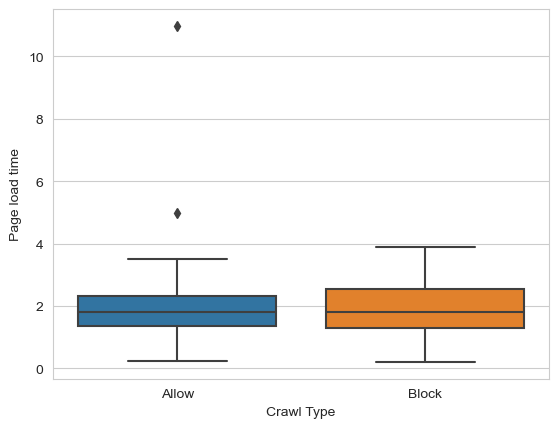

In [117]:
combined = [(value, 'Allow') for value in page_load_times_allow] + [(value, 'Block') for value in page_load_times_block]
analysis2 = pd.DataFrame(combined, columns=['Page load time', 'Crawl Type'])
sns.set_style("whitegrid")
sns.boxplot(x = 'Crawl Type', y = 'Page load time', data = analysis2) 

- Number of requests

In [118]:
def count_num_requests(directory):
    dic = {}
    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            dic[filename] = 0
            har_data = load_file(file_path)
            for entry in har_data['log']['entries']:
                request = entry['request']
                dic[filename] +=1
    return dic 

requests_allow = count_num_requests(directory_allow)
requests_block = count_num_requests(directory_block)

In [119]:
df_request_allow = pd.DataFrame.from_dict(requests_allow, orient='index', columns=['Number requests'])
df_request_allow['Type'] = 'Allow'
df_request_block = pd.DataFrame.from_dict(requests_block, orient='index', columns=['Number requests'])
df_request_block['Type'] = 'Block'
df_number_request = pd.concat([df_request_allow, df_request_block])

<Axes: xlabel='Type', ylabel='Number requests'>

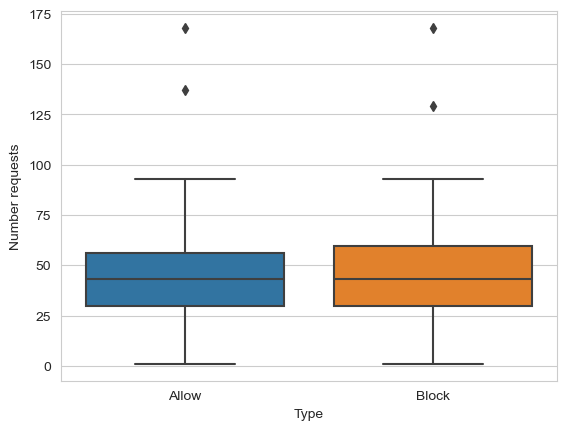

In [120]:
sns.set_style("whitegrid")   
sns.boxplot(x = 'Type', y = 'Number requests', data = df_number_request) 

- Numbers of distincs third party domains

In [121]:
def count_third_party(directory):
    third_party_domains = set()
    dic = {}
    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            dic[filename] = 0
            har_data = load_file(file_path)
            main_title = har_data['log']['pages'][0]['title']
            main_domain = extract_domain_info(main_title)
            for entry in har_data['log']['entries']:
                url = entry['request']['url']
                domain = extract_domain_info(url)
                if domain and domain != main_domain and domain not in third_party_domains:
                    third_party_domains.add(domain)
                    dic[filename] += 1
    return dic
third_party_allow = count_third_party(directory_allow)
third_party_block = count_third_party(directory_block)

<Axes: xlabel='Type', ylabel='Number third-party'>

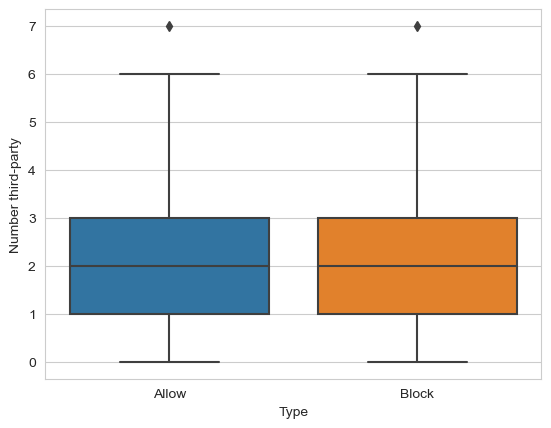

In [122]:
df_third_party_allow = pd.DataFrame.from_dict(third_party_allow, orient='index', columns=['Number third-party'])
df_third_party_allow['Type'] = 'Allow'
df_third_party_block = pd.DataFrame.from_dict(third_party_block, orient='index', columns=['Number third-party'])
df_third_party_block['Type'] = 'Block'
df_third_party = pd.concat([df_third_party_allow, df_third_party_block])
sns.set_style("whitegrid")   
sns.boxplot(x = 'Type', y = 'Number third-party', data = df_third_party) 

- Number of distinct tracker domains


In [125]:
disconnect_domains = []
disconnect = load_file("../utils/services.json")
for elem in disconnect['categories']:
    for item in disconnect['categories'][elem]:
        for value in item.values():
            for sub_value in value.values():
                for domain in sub_value:
                    if domain not in disconnect_domains:
                        disconnect_domains.append(domain)


In [124]:
def count_tracker_domains(directory):
    tracker_domains = set()
    dic = {}
    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            dic[filename] = 0
            har_data = load_file(file_path)
            main_title = har_data['log']['pages'][0]['title']
            main_domain = extract_domain_info(main_title)
            for entry in har_data['log']['entries']:
                url = entry['request']['url']
                domain = extract_domain_info(url)
                if domain and domain != main_domain and domain not in tracker_domains and domain in disconnect_domains:
                    tracker_domains.add(domain)
                    dic[filename] += 1
    return dic
tracker_domain_allow = count_tracker_domains(directory_allow)
tracker_domain_block = count_tracker_domains(directory_block)

<Axes: xlabel='Type', ylabel='Number tracker_domain'>

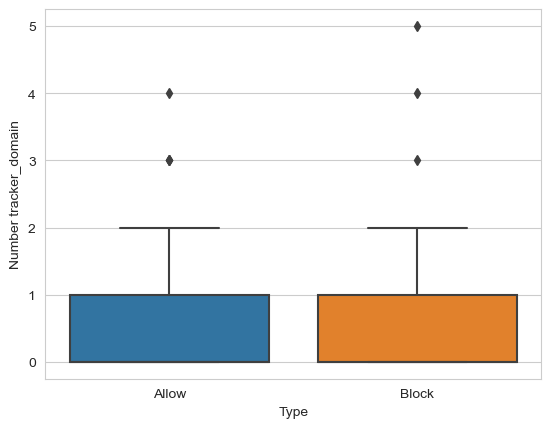

In [126]:
df_tracker_domain_allow = pd.DataFrame.from_dict(tracker_domain_allow, orient='index', columns=['Number tracker_domain'])
df_tracker_domain_allow['Type'] = 'Allow'
df_tracker_domain_block = pd.DataFrame.from_dict(tracker_domain_block, orient='index', columns=['Number tracker_domain'])
df_tracker_domain_block['Type'] = 'Block'
df_tracker_domain = pd.concat([df_tracker_domain_allow, df_tracker_domain_block])
sns.set_style("whitegrid")   
sns.boxplot(x = 'Type', y = 'Number tracker_domain', data = df_tracker_domain) 

- Number of distinct third-party domains that set a cookie with SameSite=None and without the partitioned attribute

In [127]:
def count_same_site(directory):
    third_party_domains = set()
    dic = {}
    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            dic[filename] = 0
            har_data = load_file(file_path)
            main_title = har_data['log']['pages'][0]['title']
            main_domain = extract_domain_info(main_title)
            for entry in har_data['log']['entries']:
                url = entry['request']['url']
                domain = extract_domain_info(url)
                if domain and domain != main_domain and domain not in third_party_domains: 
                    third_party_domains.add(domain)
                    cookie_response = entry['response'].get('cookies', [])
                    for cookie in cookie_response:
                        if cookie.get('sameSite') == 'None':
                            if not cookie.get('Set-Cookie') or 'Partitioned' not in cookie.get('Set-Cookie'):
                                dic[filename] += 1
    return dic
same_site_allow = count_same_site(directory_allow)
same_site_block = count_same_site(directory_block)

<Axes: xlabel='Type', ylabel='Number third-party'>

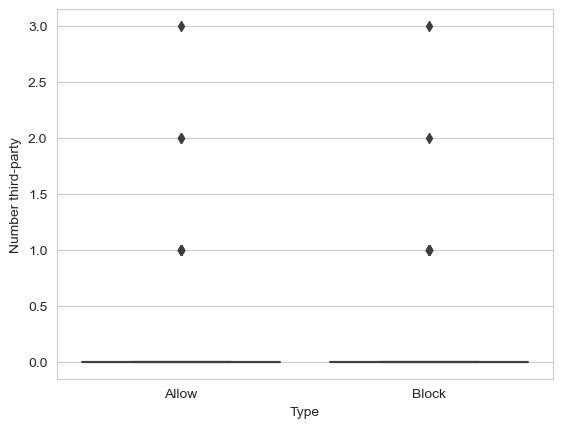

In [128]:
df_same_site_allow = pd.DataFrame.from_dict(same_site_allow, orient='index', columns=['Number third-party'])
df_same_site_allow['Type'] = 'Allow'
df_same_site_block = pd.DataFrame.from_dict(same_site_block, orient='index', columns=['Number third-party'])
df_same_site_block['Type'] = 'Block'
df_same_site = pd.concat([df_same_site_allow, df_same_site_block])
sns.set_style("whitegrid")   
sns.boxplot(x = 'Type', y = 'Number third-party', data = df_same_site) 

### Exercise 3


In [129]:
from statistics import median
data = {
    'Metric': ['Page load time (s)', 'Number of requests', 'Distinct third party domains', 'Tracker domains', 'SameSite and Partitioned'],
    'Crawl-allow Min': [min(page_load_times_allow), min(requests_allow.values()), min(third_party_allow.values()),min(tracker_domain_allow.values()),min(same_site_allow.values())],
    'Crawl-allow Median': [median(page_load_times_allow), median(requests_allow.values()),median(third_party_allow.values()),median(tracker_domain_allow.values()), median(same_site_allow.values())],
    'Crawl-allow Max': [max(page_load_times_allow), max(requests_allow.values()),max(third_party_allow.values()), max(tracker_domain_allow.values()), max(same_site_allow.values())],
    'Crawl-block Min': [min(page_load_times_block), min(requests_block.values()), min(third_party_block.values()), min(tracker_domain_block.values()),min(same_site_block.values())],  # Inserta tus propios datos aquí
    'Crawl-block Median': [median(page_load_times_block), median(requests_block.values()),median(third_party_block.values()), median(tracker_domain_block.values()),median(same_site_block.values())],  # Inserta tus propios datos aquí
    'Crawl-block Max': [max(page_load_times_block), max(requests_block.values()),max(third_party_block.values()),max(tracker_domain_block.values()), max(same_site_block.values())]  # Inserta tus propios datos aquí
}

df = pd.DataFrame(data)
df = df.applymap(lambda x: f"{x:.3f}" if isinstance(x, float) else x)
df


,Metric,Crawl-allow Min,Crawl-allow Median,Crawl-allow Max,Crawl-block Min,Crawl-block Median,Crawl-block Max
0,Page load time (s),0.233,1.807,10.980,0.208,1.822,3.908
1,Number of requests,1.000,43.000,168.000,1.000,43.000,168.000
2,Distinct third party domains,0.000,2.000,7.000,0.000,2.000,7.000
3,Tracker domains,0.000,0.000,4.000,0.000,0.000,5.000
4,SameSite and Partitioned,0.000,0.000,3.000,0.000,0.000,3.000


### Exercise 4
- should we make two separate tables or one with 20 rows?

In [130]:
def prevalent_third_party(directory):
    websites_tracker_info = {}
    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            har_data = load_file(file_path)
            main_title = har_data['log']['pages'][0]['title']
            main_domain = extract_domain_info(main_title)
            for entry in har_data['log']['entries']:
                url = entry['request']['url']
                domain = extract_domain_info(url)
                if domain and domain != main_domain:
                    if domain not in websites_tracker_info:
                        websites_tracker_info[domain] = [1, 'Yes' if domain in disconnect_domains else 'No']
                    else: 
                        websites_tracker_info[domain][0] += 1  
    
    return websites_tracker_info

prevalent_allow = prevalent_third_party(directory_allow)
prevalent_block = prevalent_third_party(directory_block)

In [112]:
prevalent_allow = dict(sorted(prevalent_allow.items(), key=lambda x: x[1][0], reverse=True)[:10])
values_list = list(prevalent_allow.values())
data = {
    'Third-party domain': list(prevalent_allow.keys()),
    'Number of distinct websites (Crawl-allow)': [x[0] for x in values_list],
    'is Tracker?': [x[1] for x in values_list]}
pd.DataFrame(data)

,Third-party domain,Number of distinct websites (Crawl-allow),is Tracker?
0,gelderland.nl,156,No
1,gov.nl,101,No
2,rotterdam.nl,77,No
3,limburg.nl,74,No
4,noord-holland.nl,65,No
5,amsterdam.nl,63,No
6,zuid-holland.nl,61,No
7,denhaag.nl,60,No
8,digid.nl,58,No
9,rvo.nl,56,No


In [111]:
prevalent_block = dict(sorted(prevalent_block.items(), key=lambda x: x[1][0], reverse=True)[:10])
values_list = list(prevalent_block.values())
data = {
    'Third-party domain': list(prevalent_block.keys()),
    'Number of distinct websites (Crawl-block)': [x[0] for x in values_list],
    'is Tracker?': [x[1] for x in values_list]}
pd.DataFrame(data)

,Third-party domain,Number of distinct websites (Crawl-block),is Tracker?
0,gelderland.nl,156,No
1,gov.nl,101,No
2,rotterdam.nl,77,No
3,limburg.nl,74,No
4,digid.nl,69,No
5,zuid-holland.nl,67,No
6,noord-holland.nl,65,No
7,amsterdam.nl,63,No
8,denhaag.nl,60,No
9,rvo.nl,55,No


### Exercise 5

In [113]:
def frequency_methods(directory):
    frequency_methods = {}
    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            har_data = load_file(file_path)
            for entry in har_data['log']['entries']:
                headers_request = entry['request']
                method = headers_request.get("method")
                if method not in frequency_methods:
                    frequency_methods[method] = 1
                else:
                    frequency_methods[method] += 1          
    return frequency_methods

frequency_methods_allow = frequency_methods(directory_allow)
frequency_methods_block = frequency_methods(directory_block)

In [114]:
data = {
    'HTTP Method': ['GET', 'POST', 'HEAD'],
    'Number of requests with method: Crawl-Allow': [frequency_methods_allow['GET'], frequency_methods_allow['POST'],frequency_methods_allow['HEAD']],  
    'Number of requests with method: Crawl-Block': [frequency_methods_block['GET'], frequency_methods_block['POST'], frequency_methods_block['HEAD']]  
}
data
pd.DataFrame(data)

,HTTP Method,Number of requests with method: Crawl-Allow,Number of requests with method: Crawl-Block
0,GET,2272,2249
1,POST,122,109
2,HEAD,1,1


### Exercise 6

In [204]:
har_data['log']['entries'][0]['request']['url']

'https://www.acm.nl/'

In [161]:
def analyze_permissions(directory):
    permissions_lists = {
        "Crawl-allow_camera": [],
        "Crawl-allow_geolocation": [],
        "Crawl-allow_microphone": [],
        "Crawl-block_camera": [],
        "Crawl-block_geolocation": [],
        "Crawl-block_microphone": []
    }

    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            har_data = load_file(file_path)
            for entry in har_data['log']['entries']:
                response_headers = entry['response']['headers']
                permissions_policy = None
                for header in response_headers:
                    if header['name'] == 'Permissions-Policy':
                        permissions_policy = header['value']
                        break
                if permissions_policy:
                    website = entry['request']['url']
                    if "camera=()" in permissions_policy:
                        if "crawl-allow" in filename:
                            permissions_lists["Crawl-allow_camera"].append(website)
                        else:
                            permissions_lists["Crawl-block_camera"].append(website)
                    if "geolocation=()" in permissions_policy:
                        if "crawl-allow" in filename:
                            permissions_lists["Crawl-allow_geolocation"].append(website)
                        else:
                            permissions_lists["Crawl-block_geolocation"].append(website)
                    if "microphone=()" in permissions_policy:
                        if "crawl-allow" in filename:
                            permissions_lists["Crawl-allow_microphone"].append(website)
                        else:
                            permissions_lists["Crawl-block_microphone"].append(website)

    return permissions_lists
analyze_permissions = analyze_permissions(directory_allow)

In [158]:
analyze_permissions

{'Crawl-allow_camera': [],
 'Crawl-allow_geolocation': [],
 'Crawl-allow_microphone': [],
 'Crawl-block_camera': ['https://www.nwo.nl/',
  'https://www.nwo.nl/calamity/check',
  'https://www.nwo.nl/cookies/consent/callback.json'],
 'Crawl-block_geolocation': ['https://www.nwo.nl/',
  'https://www.nwo.nl/calamity/check',
  'https://www.nwo.nl/cookies/consent/callback.json'],
 'Crawl-block_microphone': ['https://www.nwo.nl/',
  'https://www.nwo.nl/calamity/check',
  'https://www.nwo.nl/cookies/consent/callback.json']}

### Exercise 7

In [223]:
import os
from collections import defaultdict

def analyze_referrer_policy(directory):
    no_referrer_sites = set()
    unsafe_url_sites = set()

    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")
            har_data = load_file(file_path)
            for entry in har_data['log']['entries']:
                response_headers = entry['response']['headers']
                url = entry['request']['url']
                # Extract Referrer-Policy headers
                for header in response_headers:
                    if header['name'].lower() == 'referrer-policy':
                        policy_value = header['value'].strip().lower()
                        # Check for no-referrer and unsafe-url values
                        if policy_value == 'no-referrer':
                            no_referrer_sites.add(har_data['log']['entries'][0]['request']['url'])
                        elif policy_value == 'unsafe-url':
                            unsafe_url_sites.add(har_data['log']['entries'][0]['request']['url'])

    return no_referrer_sites, unsafe_url_sites

no_referrer_sites_allow, unsafe_url_sites_allow = analyze_referrer_policy(directory_allow)
no_referrer_sites_block, unsafe_url_sites_block = analyze_referrer_policy(directory_block)

In [225]:
print("No referrer sites allow:", no_referrer_sites_allow)
print("Unsafe url sites allow:", unsafe_url_sites_allow)
print("No referrer sites block:", no_referrer_sites_block)
print("Unsafe url sites allow:", unsafe_url_sites_allow)

No referrer sites allow: {'https://ind.nl/', 'https://www.provinciegroningen.nl/', 'https://www.noord-holland.nl/', 'https://www.gelderland.nl/', 'https://business.gov.nl/', 'https://www.digid.nl/', 'https://www.denhaag.nl/', 'https://www.werk.nl/', 'https://www.studyinnl.org/'}
Unsafe url sites allow: {'https://www.utrecht.nl/'}
No referrer sites block: {'https://ind.nl/', 'https://www.provinciegroningen.nl/', 'https://www.noord-holland.nl/', 'https://www.gelderland.nl/', 'https://business.gov.nl/', 'https://www.digid.nl/', 'https://www.denhaag.nl/', 'https://www.werk.nl/', 'https://www.studyinnl.org/'}
Unsafe url sites allow: {'https://www.utrecht.nl/'}
